In [2]:
import geopandas as gpd
import os
import xarray as xr
import numpy as np
import pandas as pd
import copy
import pickle
import gc
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#import leafmap
import leafmap.foliumap as leafmap
from shapely.geometry import mapping
import pyproj
import folium
from glob import glob

/opt/conda/envs/eurac_env/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_462785/3176613751.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [2]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [3]:
from glob import glob
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")
len(pv_farms)

3687

In [5]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

In [6]:
# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32632 = big_pv_geoms.to_crs(32632)
big_pv_geoms_32632_buffer_20 = copy.deepcopy(big_pv_geoms_32632)
big_pv_geoms_32632_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32632_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32632_buffer_20.to_crs(4326)


print(f"Number of selected PV Farms: {len(big_pv_geoms_buffer)}")

Number of selected PV Farms: 4458


In [7]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

### Extract the data and save them as numpy arrays
Run this section just for the first time

In [8]:
# Plot random PV farm
farm_id = 2

data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
geom = big_pv_geoms_32632.iloc[farm_id]  

# This step to fill the gaps (nan values) spatially
data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
data.rio.write_crs("epsg:32633", inplace=True) #32633

# Filter clouds pixels
cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
data = data.where(~cloud_mask)

# Clip the farm polygon
clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

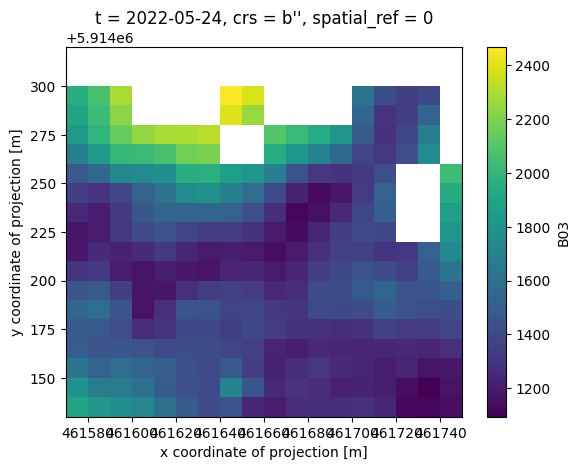

In [9]:
data['B03'][55].plot()

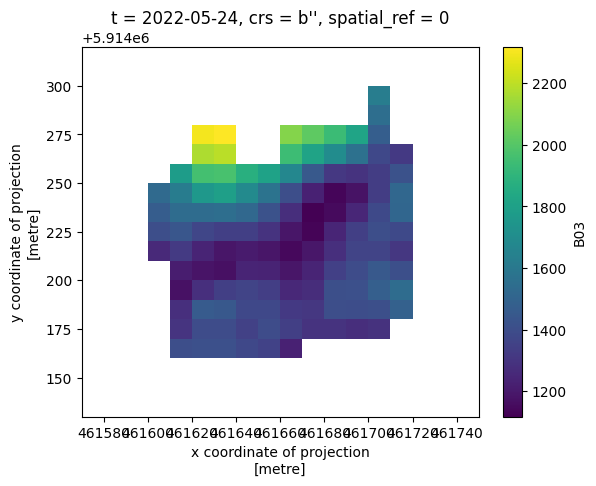

In [10]:
clipped['B03'][55].plot()

In [11]:
def s2_data(pv_farms, start_date='2022-01-01', end_date='2022-12-31',train=True, invert=False):
    
    all_pixels_ts = []
    for pv_farm in pv_farms:
        farm_id = int(pv_farm.split('/')[-1].split('_')[-1].split('.')[0])
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
        geom = big_pv_geoms_32632.iloc[farm_id]


         ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633   

        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')    

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')   


        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=invert)


        if train:
            df = clipped.to_dataframe().unstack(level='t')
        else:
            df = ds_daily_interp.to_dataframe().unstack(level='t')
        
        arr_ts= []
        for b in bands:
            df_b = df[b]
            if train:
                df_b = df_b.dropna(how = 'all')
            if invert:
                # Randomly select 25% of the pixels 
                rows_to_filter = int(0.25 * len(df_b))
                df_b = df_b.sample(n=rows_to_filter, random_state=42)
                
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))
        
    
    samples = np.vstack(all_pixels_ts)

    
    return samples

In [ ]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")
pv_samples = s2_data(pv_farms[500:])
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy', pv_samples)

In [ ]:
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")

non_pv_samples = s2_data(pv_farms[500:], invert=True)
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy', non_pv_samples)

### Modeling

In [21]:
import numpy as np
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy')
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy')

y1 = np.ones(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])


In [22]:
print(pv_samples.shape)
print(non_pv_samples.shape)

(805869, 11, 365)
(592414, 11, 365)


In [23]:
tr_data = np.vstack([pv_samples[:100000], non_pv_samples[:100000]])
y = np.hstack([y1[:100000], y0[:100000]])

tr_data = np.nan_to_num(tr_data, nan=-999999)

In [24]:
tr_data = tr_data.reshape(tr_data.shape[0], tr_data.shape[1]*tr_data.shape[2])
tr_data.shape

(200000, 4015)

In [25]:
del non_pv_samples, pv_samples, y1, y0 ; gc.collect()

22

In [26]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
scores = []
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=2024)
    clf.fit(x_train, y_train)
    
    
    # Validation
    y_pred = clf.predict(x_val)
    score = accuracy_score(y_pred, y_val)
    scores.append(score)
    print(f'Accuracy Score: {score}')
    
    filename = f'../models/non_temporal_models/rf_non_temporal_{i+1}.sav'
    pickle.dump(clf, open(filename, 'wb'))
    
    i+=1
    break
print(f'Average F1 Score: {np.mean(scores)}')

########### Fold number 1 
Accuracy Score: 0.743975
Average F1 Score: 0.743975


In [27]:
del tr_data, x_train, x_val, y_train, y_val; gc.collect()

0

### Inference  

#### Extrac the dataset 
Run it for the first time

In [27]:
from glob import glob
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")
te_pv_samples = s2_data(pv_farms[:500])
te_non_pv_samples = s2_data(pv_farms[:500], invert=True)

np.save(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy', te_pv_samples)
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy', te_non_pv_samples)


This polygon id: 0 is not exist.
This polygon id: 1 is not exist.
This polygon id: 6 is not exist.
This polygon id: 9 is not exist.
This polygon id: 17 is not exist.
This polygon id: 27 is not exist.
This polygon id: 29 is not exist.
This polygon id: 56 is not exist.
This polygon id: 62 is not exist.
This polygon id: 65 is not exist.
This polygon id: 69 is not exist.
This polygon id: 74 is not exist.
This polygon id: 84 is not exist.
This polygon id: 87 is not exist.
This polygon id: 97 is not exist.
This polygon id: 99 is not exist.
This polygon id: 103 is not exist.
This polygon id: 107 is not exist.
This polygon id: 118 is not exist.
This polygon id: 124 is not exist.
This polygon id: 130 is not exist.
This polygon id: 138 is not exist.
This polygon id: 140 is not exist.
This polygon id: 143 is not exist.
This polygon id: 170 is not exist.
This polygon id: 171 is not exist.
This polygon id: 177 is not exist.
This polygon id: 184 is not exist.
This polygon id: 186 is not exist.
This 

#### test predctions

In [28]:
te_non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy')
te_non_pv_samples = np.nan_to_num(te_non_pv_samples, nan=-999999)

te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy')
te_pv_samples = np.nan_to_num(te_pv_samples, nan=-999999)

y1 = np.ones(te_pv_samples.shape[0])
y0 = np.zeros(te_non_pv_samples.shape[0])

te_samples = np.vstack([te_pv_samples, te_non_pv_samples])
te_samples = te_samples.reshape(te_samples.shape[0], te_samples.shape[1]*te_samples.shape[2])
y_test = np.hstack([y1, y0])

In [33]:
clf = pickle.load(open(f'../models/non_temporal_models/rf_non_temporal_1.sav', 'rb'))
te_pred = clf.predict(te_samples)

test_score = accuracy_score(te_pred, y_test)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.6885473829746744


In [34]:
te_pv_samples = te_pv_samples.reshape(te_pv_samples.shape[0], te_pv_samples.shape[1]*te_pv_samples.shape[2])
te_pred = clf.predict(te_pv_samples)

test_score = accuracy_score(te_pred, y1)
print(f'Test Accuracy Score for PV pixels: {test_score}')

Test Accuracy Score for PV pixels: 0.7550569693319279


### Leaf map

In [35]:
# Load the trained classifier 
clf = pickle.load(open(f'../models/non_temporal_models/rf_non_temporal_1.sav', 'rb'))

In [36]:
leafmap.search_qms(keyword="google")

['qms.basemap.at',
 'qms.basemap.at Orthofoto',
 'qms.EOX::Maps - Sentinel-2 cloudless',
 'qms.Geoland Basemap',
 'qms.Geoland Basemap Gelände',
 'qms.Geoland Basemap Grau',
 'qms.Geoland Basemap High DPI',
 'qms.Geoland Basemap Oberfläche',
 'qms.Geoland Basemap Orthofoto',
 'qms.Geoland Basemap Overlay']

In [37]:
def json_s2_boundary(coords):
    bounds = (
        float(coords['x'].min()),  # minx
        float(coords['y'].min()),  # miny
        float(coords['x'].max()),  # maxx
        float(coords['y'].max())   # maxy
    )
    
    # Define the bounds
    minx, miny, maxx, maxy = bounds
    
    # Define the coordinates for the rectangle
    rectangle_coords = [
        [ minx, miny],
        [maxx,miny],
        [maxx, maxy],
        [minx, maxy],
        [minx, miny]  
        
    ]
    
    
    # Create a GeoJSON object for the rectangle
    rectangle_geojson = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [rectangle_coords]
                },
                "properties": {}
            }
        ]
    }
    
    return rectangle_geojson


In [38]:
def extract_test_data(farm_id):
    start_date = '2022-01-01'
    end_date = '2022-12-31'
    
    all_pixels_ts = []
    
    geom = big_pv_geoms_buffer.iloc[farm_id]
    farm_id = geom.name
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
        coords = data.rio.reproject("EPSG:4326").coords
        s2_boundaries = json_s2_boundary(coords)
        
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')
        
        #clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = ds_daily_interp.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            #df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1)) 
        te_samples = np.vstack(all_pixels_ts)
        te_samples = np.nan_to_num(te_samples, nan=-999999)

        
        te_samples = te_samples.reshape(te_samples.shape[0], te_samples.shape[1]*te_samples.shape[2])
        df_normal = df_b.reset_index()
        x_coords = df_normal[['x', 'y']].values[:,0]
        y_coords = df_normal[['x', 'y']].values[:,1]


        return te_samples, x_coords, y_coords, s2_boundaries
    
    except:
        print(f"This farm : {farm_id} is not exist.")  
        

In [39]:
def farm_plot(farm_id, s2_boundaries):
    geom_wgs84 = big_pv_geoms_buffer.iloc[farm_id]
    centroid = geom_wgs84.geometry.centroid
    
    # Add the PV farm boundaries
    ## Convert the polygon boundary to GeoJSON format
    geojson_farm = mapping(geom_wgs84.geometry)    
    m = leafmap.Map(center=[centroid.y, centroid.x], zoom=15)
    m.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")
    folium.GeoJson(geojson_farm).add_to(m)
    
    # Add s2 boundaries
    folium.GeoJson(s2_boundaries).add_to(m)
    
    return m, geojson_farm

In [40]:
# Input the farm id in the GDF
te_samples, x_coords, y_coords, s2_boundaries = extract_test_data(farm_id = 278)
te_samples.shape

(4851, 4015)

In [41]:
m, geojson_farm = farm_plot(farm_id = 278, s2_boundaries = s2_boundaries)
m

In [42]:
# Predictions 
te_pred = clf.predict(te_samples)
te_pred

array([0., 0., 0., ..., 0., 0., 0.])

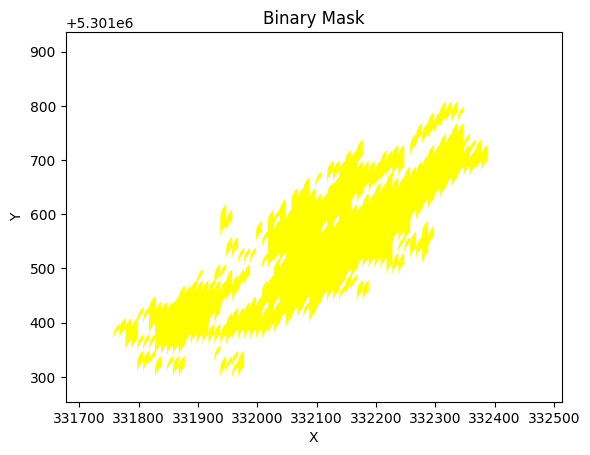

In [43]:
custom_cmap = ListedColormap(['white', 'yellow']) #yellow for 1 and white for 0

# Plot the binary mask
plt.scatter(x_coords, y_coords, c=te_pred, cmap=custom_cmap, s=500)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Mask')
plt.show()

In [44]:
def map_predictios(te_pred,x_coords, y_coords, geojson_farm, s2_boundaries):
    # Define the original CRS 
    original_crs = pyproj.CRS("EPSG:32633") 
    
    # Define the target CRS (WGS84)
    target_crs = pyproj.CRS("EPSG:4326")
    
    # Create a pyproj transformer to perform the coordinate transformation
    transformer = pyproj.Transformer.from_crs(original_crs, target_crs, always_xy=True)
    
    # Transform coordinates from the original CRS to WGS84
    lon, lat = transformer.transform(x_coords, y_coords)
    
    # Create a map centered at the mean of coordinates
    min_x, max_x = np.min(lon), np.max(lon)
    min_y, max_y = np.min(lat), np.max(lat)
    center = [(min_y + max_y) / 2, (min_x + max_x) / 2]
    m = leafmap.Map(location=center, zoom_start=15)
    m.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")
    
    # Add farm boundaries
    folium.GeoJson(geojson_farm).add_to(m)
    
    # Add s2 boundaries
    folium.GeoJson(s2_boundaries).add_to(m)
    
    # Iterate over each point in the array
    for x, y, value in zip(lon, lat, te_pred):
        # Add a marker with color based on the value
        if value == 1:
            folium.CircleMarker(
                location=[y, x],  
                radius=5,
                color='red',
                fill=True,
                fill_color='red'
            ).add_to(m)
            
    return m
        

In [45]:
map_predictios(te_pred,x_coords, y_coords, geojson_farm, s2_boundaries)